In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

import arviz as az

import stan

from jax import jacobian
from jax.experimental.ode import odeint
import jax.numpy as jnp

from s3fs.core import S3FileSystem

import lotka_volterra
from mcmc import sample_chain, metropolis_random_walk_step, rw_proposal_sampler
import utils.caching
from utils.caching import make_cached_s3
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel_joblib
from utils.paths import FIGURES_PATH, S3_BUCKET_NAME
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [5]:
cached = make_cached_s3(S3_BUCKET_NAME)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_2$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

The model is defined in module `lotka_volterra`.

Plot the resulting values:

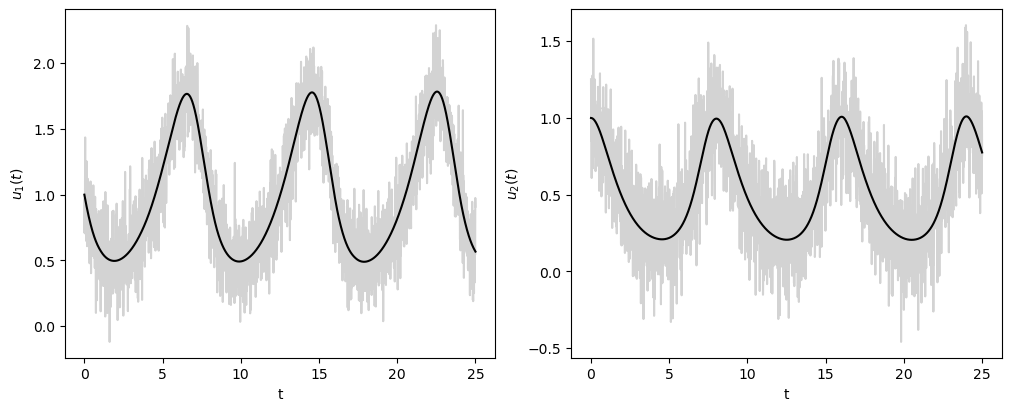

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
#fig.suptitle('Lotka-Volterra solution with added Gaussian noise');
for i in range(2):
    axs[i].plot(lotka_volterra.t, lotka_volterra.y[:, i], color='lightgray');
    axs[i].plot(lotka_volterra.t, lotka_volterra.u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

fig.savefig(FIGURES_PATH / 'lotka-volterra.eps');

In [8]:
save_data = False

In [9]:
if save_data:
    df = pd.DataFrame(
        {'u1': lotka_volterra.y[:, 0], 'u2': lotka_volterra.y[:, 1]},
        index=pd.Index(lotka_volterra.t, name='t')
    )
    s3 = S3FileSystem()
    with s3.open(f'{S3_BUCKET_NAME}/lotka_volterra_gaussian_noise.csv', 'w') as f:
        df.to_csv(f)

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [10]:
n_samples_rw = 500_000

In [11]:
# TODO consider selecting step size automatically following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.0025

In [12]:
rw_seed = 12345
def run_rw_sampler(theta_init):
    rng = np.random.default_rng(rw_seed)
    theta_sampler = metropolis_random_walk_step(
        lotka_volterra.log_target_density,
        rw_proposal_sampler(step_size, rng, lotka_volterra.d),
        rng,
    )
    return sample_chain(theta_sampler, np.log(theta_init), n_samples_rw)

In [13]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_samples(i) -> np.ndarray:
    return run_rw_sampler(lotka_volterra.theta_inits[i])

In [14]:
map_parallel(rw_samples.get_or_recalculate, range(lotka_volterra.n_chains));

Reproduce the first column in Figure S17 from the Supplementary Material:

In [15]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_4.npy


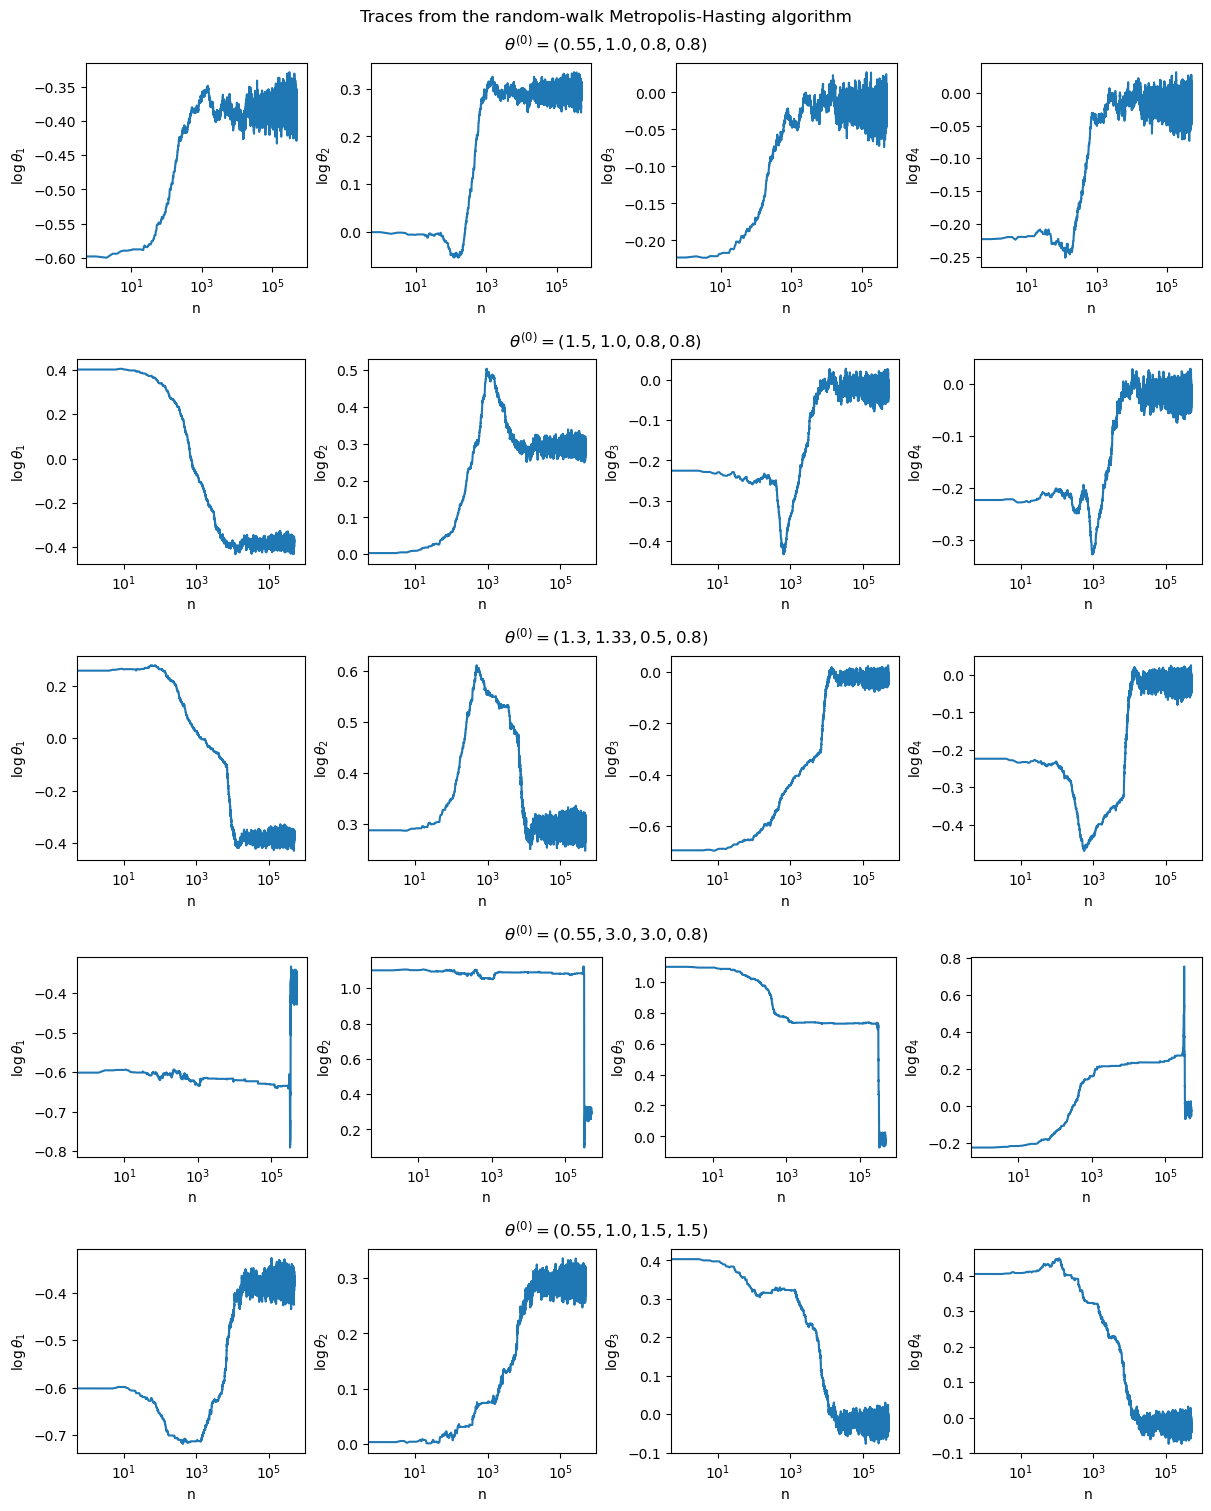

In [16]:
fig = plot_traces(rw_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the random-walk Metropolis-Hasting algorithm');

Produce a figure for the report:

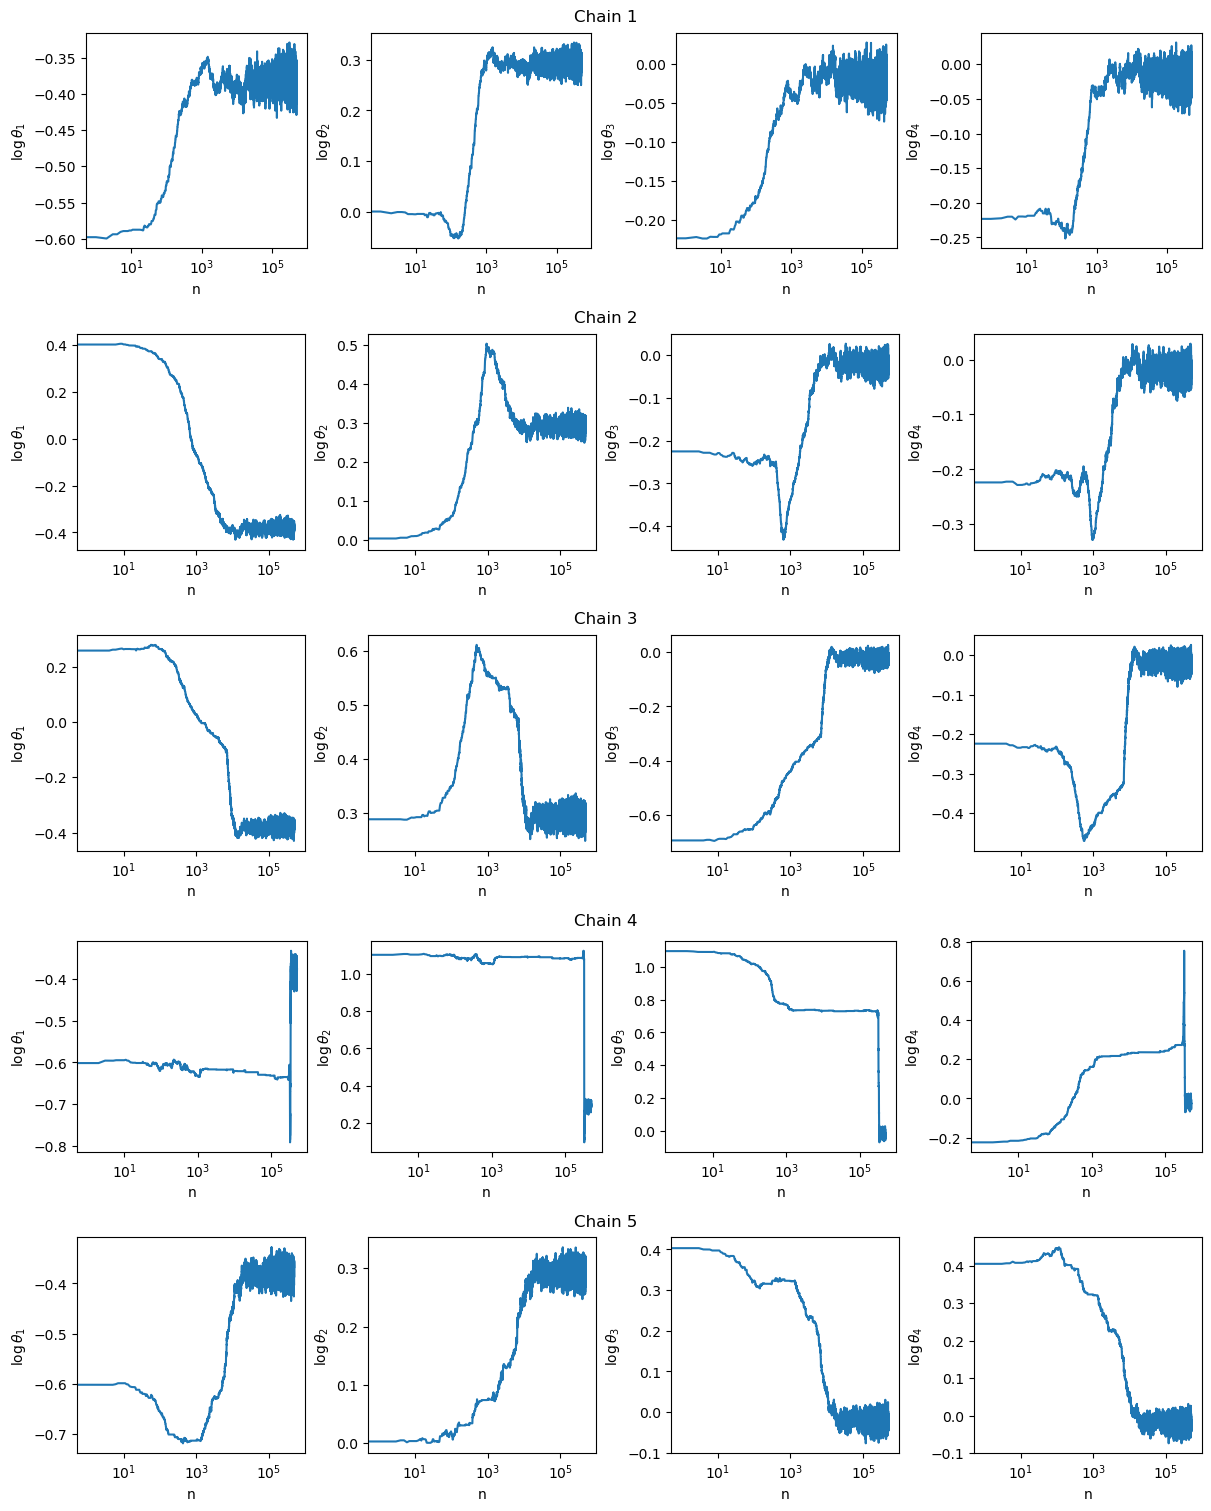

In [17]:
fig = plot_traces(rw_samples, titles=[f'Chain {i + 1}' for i in range(len(rw_samples))], var_labels=var_labels);
fig.savefig(FIGURES_PATH / 'lotka-volterra-trace-plots.eps');

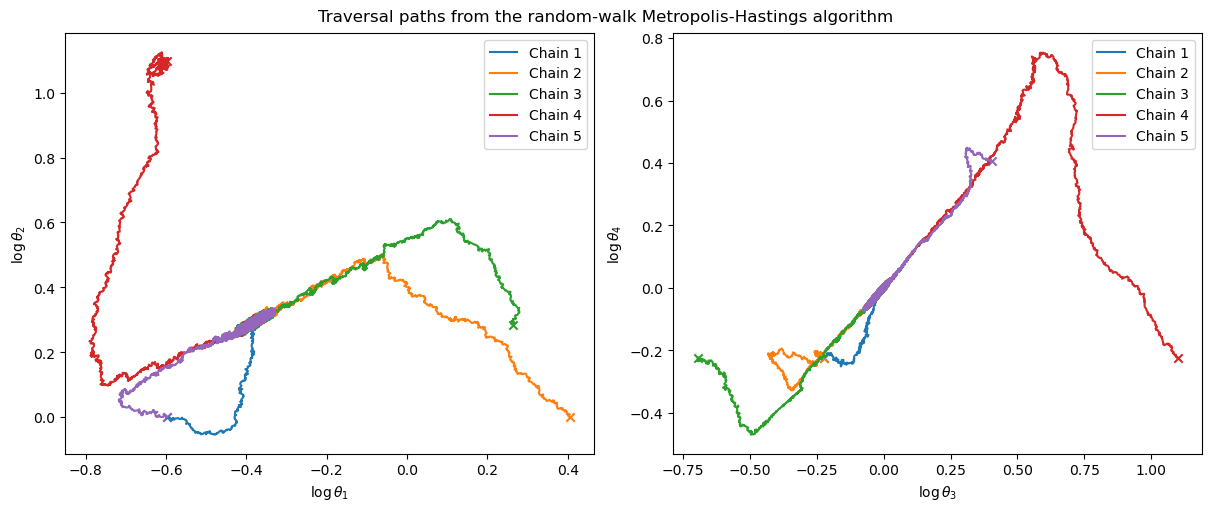

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plot_paths(rw_samples, np.log(lotka_volterra.theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(rw_samples, np.log(lotka_volterra.theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');
fig.savefig(FIGURES_PATH / 'lotka-volterra-chain-paths.png', dpi=600);
fig.suptitle('Traversal paths from the random-walk Metropolis-Hastings algorithm');

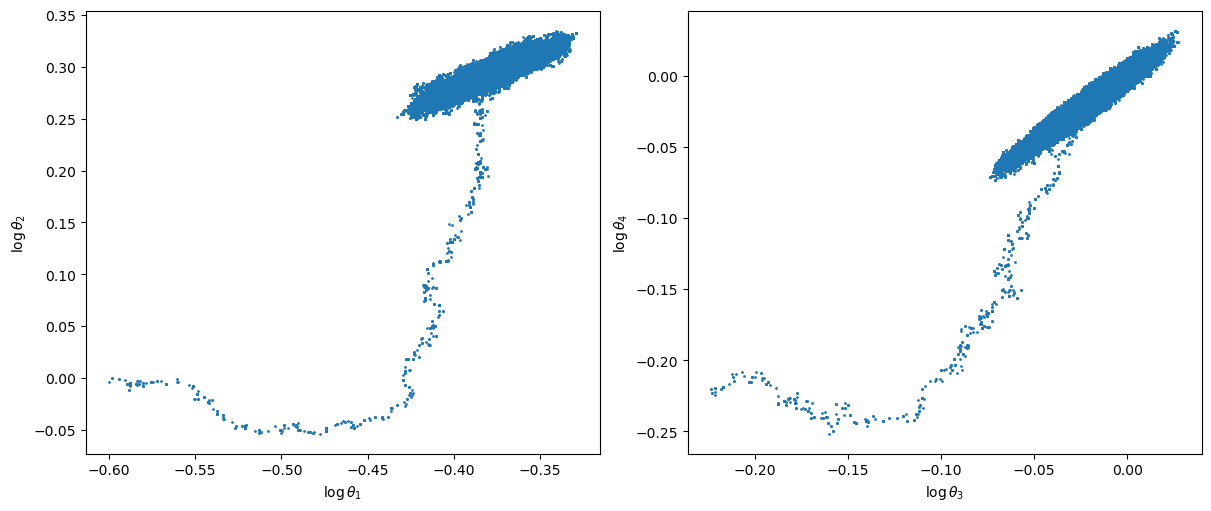

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True);
highlight_points(rw_samples[0], [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None, sample_point_alpha=1.);
fig.savefig(FIGURES_PATH / 'lotka-volterra-chain1-sample.png', dpi=300);

In [20]:
def acceptance_rate(sample):
    """Fraction of accepted samples"""
    return (np.sum(np.any(sample[1:] != sample[:-1], axis=1)) + 1) / sample.shape[0]

In [21]:
[acceptance_rate(sample) for sample in rw_samples]

[np.float64(0.2306775386449227),
 np.float64(0.23022353955292088),
 np.float64(0.22811954376091248),
 np.float64(0.07851784296431408),
 np.float64(0.22772154455691088)]

## Convergence diagnostics

``arviz`` implements $\hat{R}$ and the expected sample size as recommended in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_. The paper suggests the minimum ESS of 50 for each chain and the threshold value of 1.01 for $\hat{R}$. Based on these thresholds, the chains would be deemed not to have converged:

In [22]:
@cached()
def rw_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(rw_samples, var_names=[f'log_theta{i + 1}' for i in range(d)]))

In [23]:
rw_az_summary()

DEBUG:utils.caching:Reading from disk cache: rw_az_summary
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta1,-0.416,0.091,-0.636,-0.355,0.035,0.026,16.0,19.0,1.23
log_theta2,0.394,0.267,0.270,1.085,0.108,0.080,17.0,31.0,1.23
log_theta3,0.078,0.254,-0.044,0.736,0.103,0.077,14.0,13.0,1.28
log_theta4,0.020,0.105,-0.045,0.273,0.038,0.028,17.0,39.0,1.21


# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [24]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector log_theta) {
    vector[2] dudt;
    dudt[1] = exp(log_theta[1]) * u[1] - exp(log_theta[2]) * u[1] * u[2];
    dudt[2] = exp(log_theta[4]) * u[1] * u[2] - exp(log_theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] log_theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, log_theta);
  log_theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [25]:
data = {
    'T': lotka_volterra.t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': lotka_volterra.y[1:, :],
    't0': lotka_volterra.t_span[0],
    'ts': lotka_volterra.t[1:],
    'u0': lotka_volterra.u_init,
    'sigma': np.diag(lotka_volterra.C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [26]:
n_samples_hmc = 10_000

In [27]:
def extract_chains(stan_sample, param):
    """Extract chains from PyStan fit"""
    param_indices = stan_sample._parameter_indexes(param)
    return [stan_sample._draws[param_indices, :, i_chain].T for i_chain in range(stan_sample.num_chains)]

In [28]:
hmc_seed = 12345

In [29]:
@cached(item_type=np.ndarray, batch=True, batch_size=len(lotka_volterra.theta_inits))
def hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(lotka_volterra.theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=True,
        init=[{'log_theta': np.log(theta_init)} for theta_init in lotka_volterra.theta_inits]
    )
    return extract_chains(stan_sample, 'log_theta')

DEBUG:utils.caching:Reading from disk cache: hmc_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_samples_4.npy


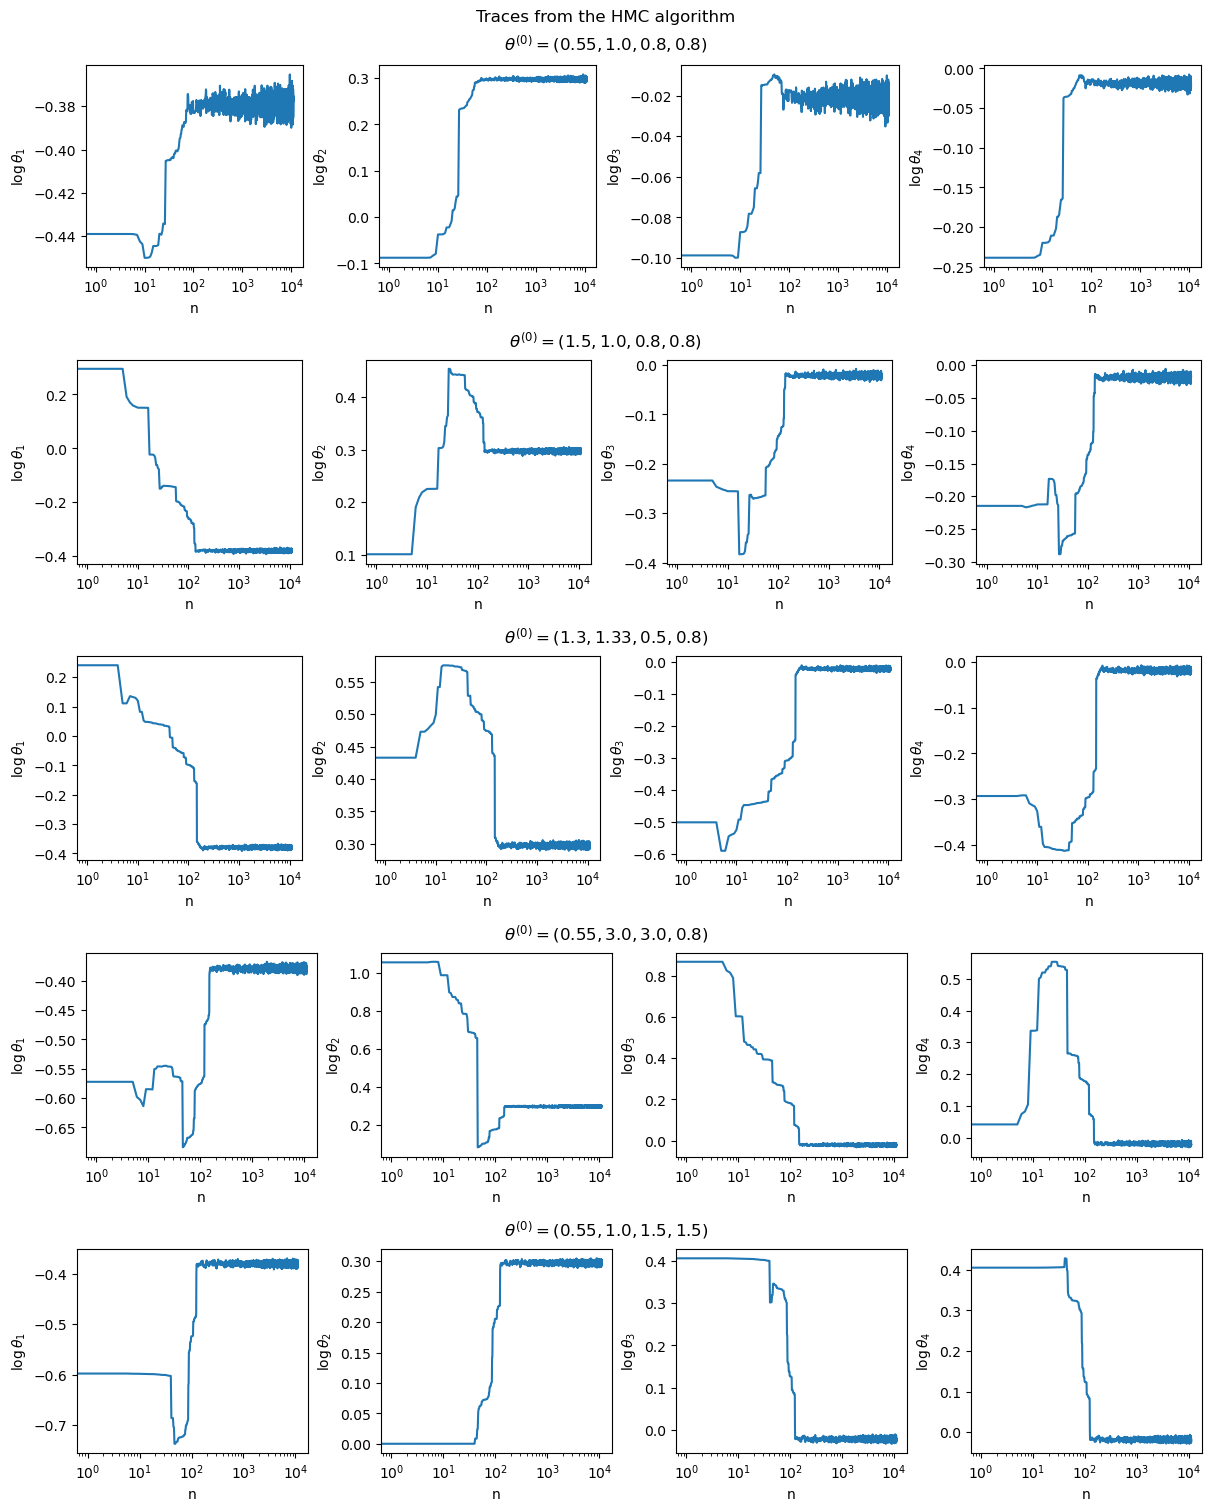

In [30]:
fig = plot_traces(hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the HMC algorithm');

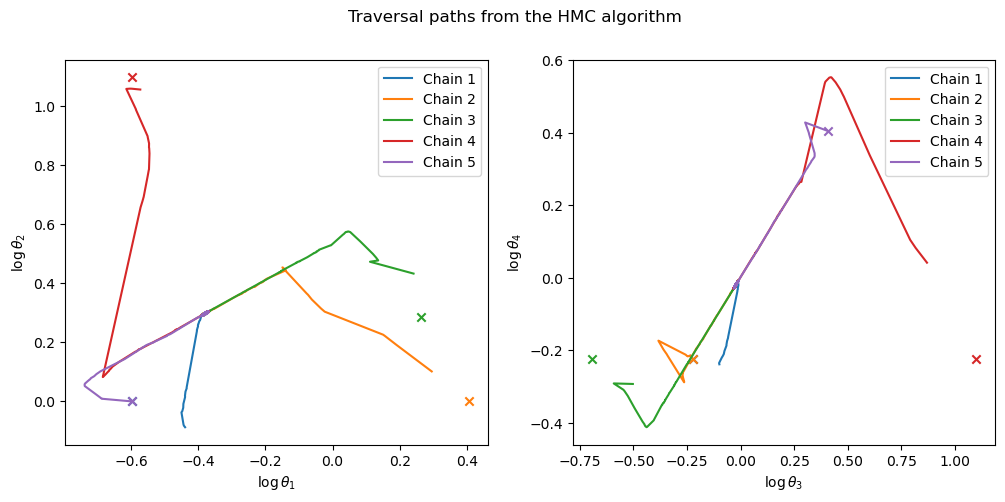

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths from the HMC algorithm');
plot_paths(hmc_samples, np.log(lotka_volterra.theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(hmc_samples, np.log(lotka_volterra.theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');

In [32]:
[acceptance_rate(sample) for sample in hmc_samples]

[np.float64(0.9928181818181818),
 np.float64(0.9916363636363636),
 np.float64(0.9904545454545455),
 np.float64(0.9908181818181818),
 np.float64(0.990909090909091)]

Based on the thresholds in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_, the diagnostics do not suggest any convergence issues:

In [33]:
@cached()
def hmc_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(hmc_samples, var_names=[f'log_theta{i + 1}' for i in range(d)]))

In [34]:
hmc_az_summary()

DEBUG:utils.caching:Reading from disk cache: hmc_az_summary
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/hmc_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta1,-0.379,0.028,-0.386,-0.373,0.002,0.001,2992.0,2735.0,1.0
log_theta2,0.298,0.025,0.293,0.302,0.001,0.001,4145.0,2989.0,1.0
log_theta3,-0.021,0.032,-0.027,-0.015,0.002,0.002,3115.0,2727.0,1.0
log_theta4,-0.019,0.030,-0.025,-0.013,0.002,0.001,3090.0,2697.0,1.0


### Validation HMC sample

We generate an additional sample that we will use to evaluate the quality of fit for the proposed methods.

In [35]:
validation_hmc_seed = 98765

In [36]:
@cached(item_type=np.ndarray, batch=True, batch_size=len(lotka_volterra.theta_inits))
def validation_hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=validation_hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(lotka_volterra.theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=False,
        init=[{'log_theta': np.log(theta_init)} for theta_init in lotka_volterra.theta_inits]
    )
    return extract_chains(stan_sample, 'log_theta')

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_4.npy


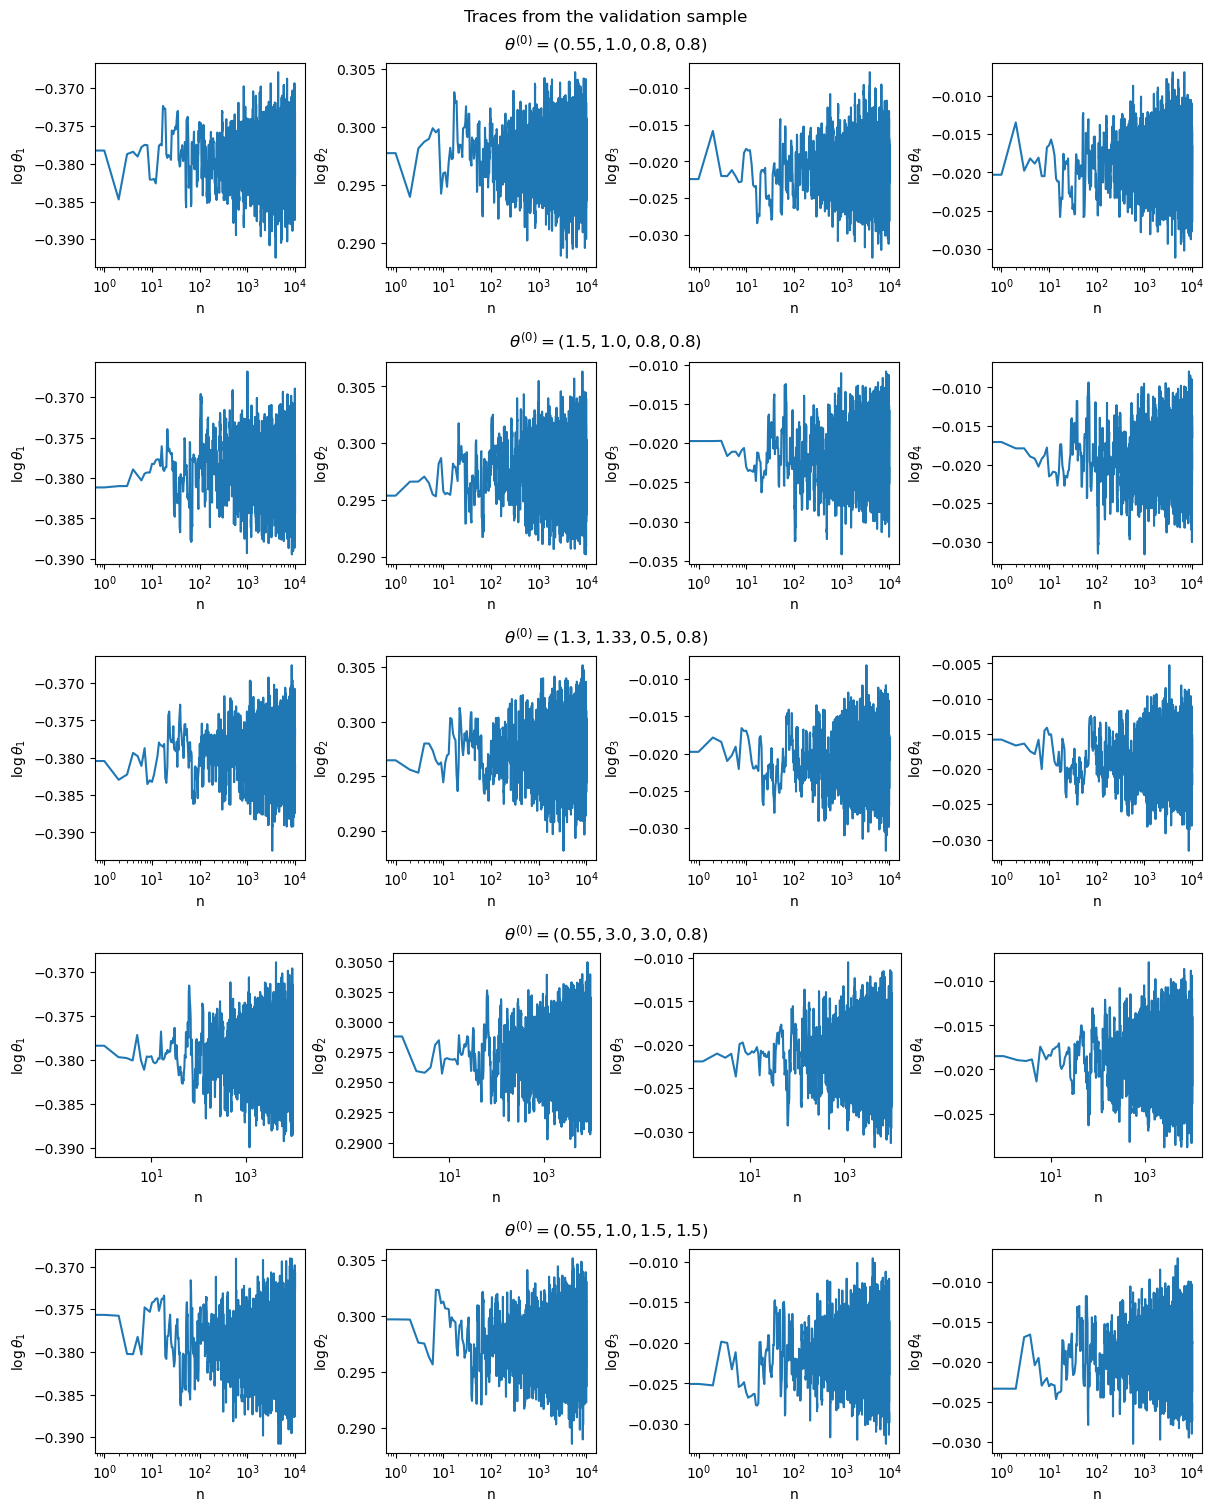

In [37]:
fig = plot_traces(validation_hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the validation sample');

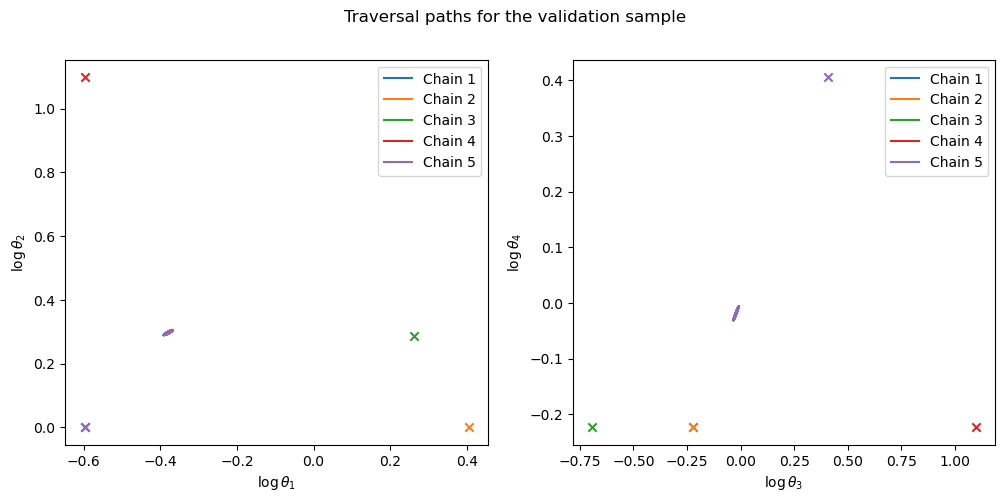

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths for the validation sample');
plot_paths(validation_hmc_samples, np.log(lotka_volterra.theta_inits), idx1=0, idx2=1, ax=axs[0],
           label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(validation_hmc_samples, np.log(lotka_volterra.theta_inits), idx1=2, idx2=3, ax=axs[1],
           label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');

In [39]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

Notebook execution took:

In [40]:
time.time() - start_time

64.71586561203003